In [13]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [8]:
import sys
print(sys.version)
nlp = spacy.load('en_core_web_sm')
df = pd.read_csv('cleaned_whole_data.csv')
df = df[df['subreddit']!='EngineeringCareers']

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Removing unicode characters
    text = re.sub(r'\\u[0-9A-Fa-f]+', '', text)
    
    # Removing escape sequences
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\\', '', text)
    
    # Removing non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing stop words and lemmatizing
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Joining back into a string
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)
df[['processed_text']].head()


3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


,processed_text
0,hi context year old guy amsterdam currently em...
1,looking new role havent much traction recently...
2,west bengal bachelor art self taught developer...
3,created m word yoe java spring boot
4,live los angeles year old


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7814 samples in 0.015s...
[t-SNE] Computed neighbors for 7814 samples in 1.744s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7814
[t-SNE] Computed conditional probabilities for sample 2000 / 7814
[t-SNE] Computed conditional probabilities for sample 3000 / 7814
[t-SNE] Computed conditional probabilities for sample 4000 / 7814
[t-SNE] Computed conditional probabilities for sample 5000 / 7814
[t-SNE] Computed conditional probabilities for sample 6000 / 7814
[t-SNE] Computed conditional probabilities for sample 7000 / 7814
[t-SNE] Computed conditional probabilities for sample 7814 / 7814
[t-SNE] Mean sigma: 0.367205
[t-SNE] KL divergence after 250 iterations with early exaggeration: 136.901947
[t-SNE] KL divergence after 300 iterations: 7.493951


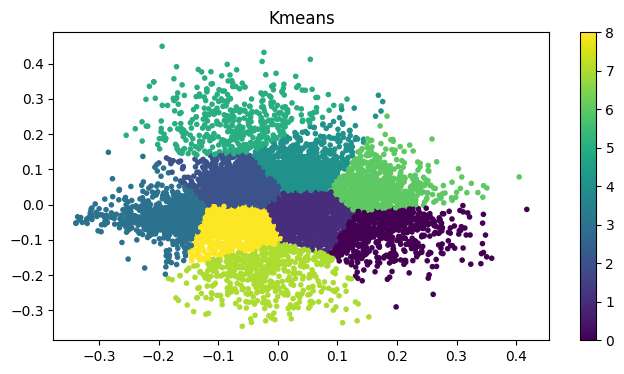

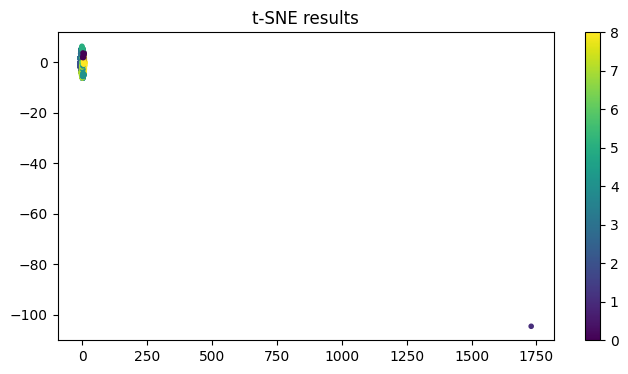

In [9]:
# Fill any NaNs
df.fillna('', inplace=True)

# Concatenate title and text for TF-IDF
df['combined_text'] = df['title'] + ' ' + df['processed_text']

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

# Dimensionality Reduction with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

# Apply k-means clustering to PCA reduced data
kmeans_pca = KMeans(n_clusters=9, random_state=42)
kmeans_pca.fit(pca_result)

# Apply k-means clustering to t-SNE reduced data
kmeans_tsne = KMeans(n_clusters=9, random_state=42)
kmeans_tsne.fit(tsne_result)

# Plotting the results of PCA
plt.figure(figsize=(8, 4))
plt.title('Kmeans')
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_pca.labels_, cmap='viridis', marker='.')
plt.colorbar()
plt.show()

# Plotting the results of t-SNE
plt.figure(figsize=(8, 4))
plt.title('t-SNE results')
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_tsne.labels_, cmap='viridis', marker='.')
plt.colorbar()
plt.show()

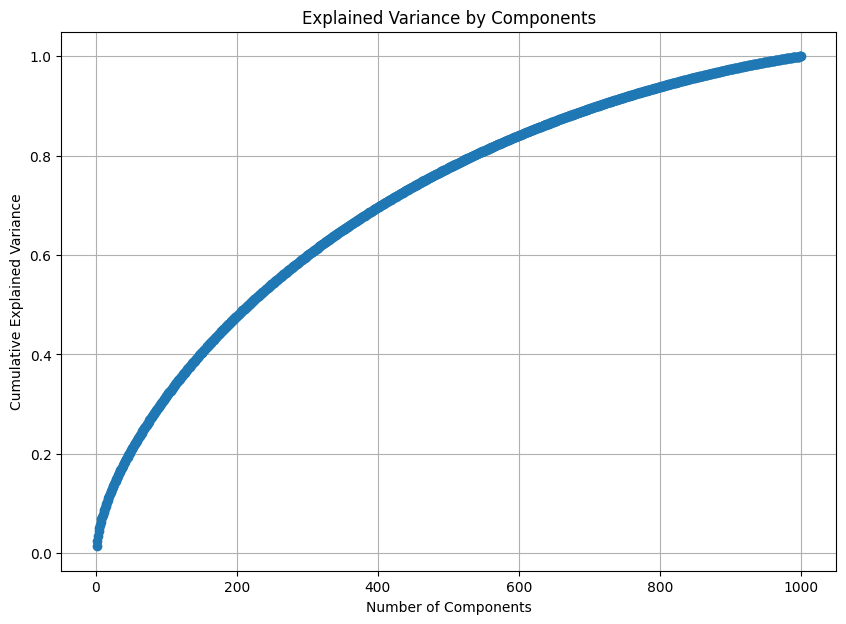

In [10]:
pca = PCA().fit(tfidf_matrix.toarray())

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [11]:
pca = PCA(n_components=800)
# Fit PCA on the dataset and transform the data
reduced_data = pca.fit_transform(tfidf_matrix.toarray())
# Fit PCA on the dataset and transform the data

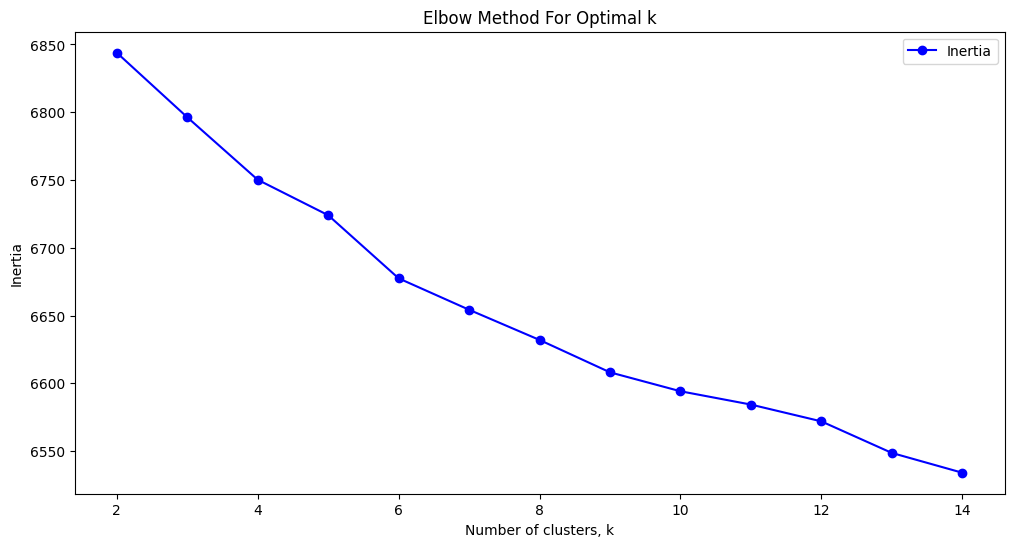

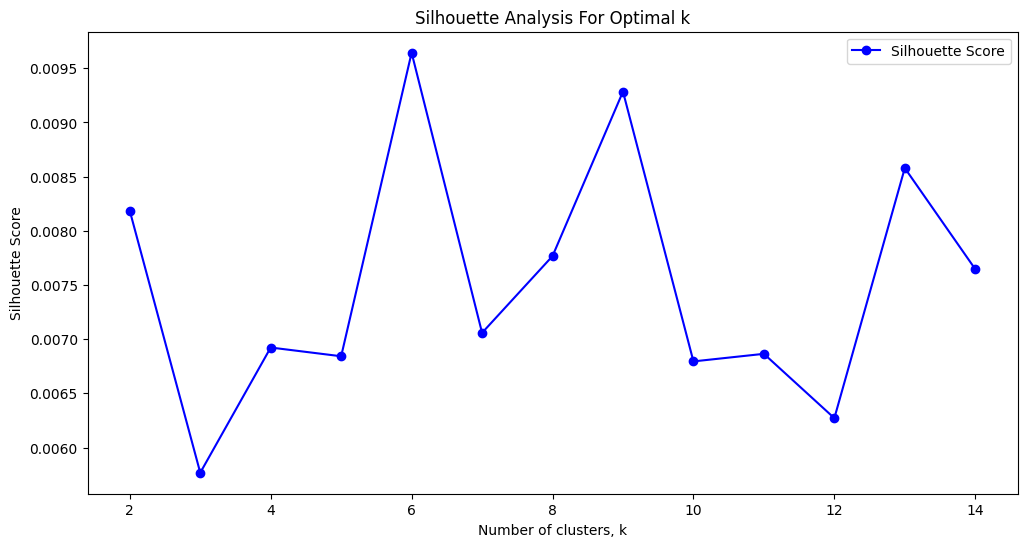

In [12]:
# Apply K-Means and calculate inertia for a range of k values
inertias = []
silhouette_scores = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))

# Elbow method plot
plt.figure(figsize=(12, 6))
plt.plot(K, inertias, 'bo-', label='Inertia')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

# Silhouette analysis plot
plt.figure(figsize=(12, 6))
plt.plot(K, silhouette_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.legend()
plt.show()